In [23]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [24]:
lep = ds.dataset(list(Path(f"halfleptonic/").glob("*.parquet")), format="parquet")

In [25]:
scanner = lep.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'cmpmiss', 'cmpmiss_ROE', 'cmthetamiss',
       'cmthetamiss_ROE', 'fox_ups', 'fox_Btag', 'asymmetry', 'pBtag',
       'theta_Btag', 'MBtag', 'rec_theta_Btag', 'idec0', 'idec1', 'is0',
       'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik', 'N_KS', 'theta_tau_0',
       'p_tau_0', 'theta_tau_1', 'p_tau_1', 'p_tau_0_tagcm', 'p_tau_1_tagcm',
       'ang_taus', 'ang_taus_tagcm', 'ang_tau0_pmiss', 'ang_tau1_pmiss',
       'ang_tau1_ROE', 'ang_tau0_ROE', 'Delta_tau1_Btag', 'Delta_tau0_Btag',
       'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0',
       'Chi_sq_1', 'dr0', 'dr1', 'totalEnergyMC', 'E_gamma_in_ROE',
       'correct_nu_0', 'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1',
       'lost_0', 'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0'

In [26]:
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012) & (pc.field("N_KS") < 0.5)
mask_M = (pc.field("MBtag") > 5.347) &  (pc.field("MBtag") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("MBtag") > 5.347) &  (pc.field("MBtag") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("MBtag") > 5.347) &  (pc.field("MBtag") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_miss_id = pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_lost_Kpi = pc.field("lost_0") & pc.field("lost_1")
mask_KS_veto = (pc.field("N_KS") == 0) & (pc.field("N_KL") == 0)

In [27]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\marc\AppData\Local\Temp\ipykernel_17524\1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [28]:
import json
with open("output/columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [29]:
data = get_values(lep, columns + ['E_gamma_in_ROE', 'MBtag'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))

Total data size: 3.28 MB


In [30]:
from xgboost import XGBClassifier
import json
model = XGBClassifier()
model.load_model("output/bdt_model.json")
with open("output/columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [31]:
X_new = data[columns]

bdt_scores = model.predict_proba(X_new)[:, 1] 

data["bdt_score"] = bdt_scores

selected_mask = data["bdt_score"] > FoM

selected_data = data[selected_mask]

In [8]:
wbin = 0.05
a = 0 
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

In [9]:
BS0 = 5.366691

In [32]:
wbin_x, a_x, b_x = 0.05, 0, 1.2
wbin_y, a_y, b_y = 0.005, 5.25, 5.5

bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

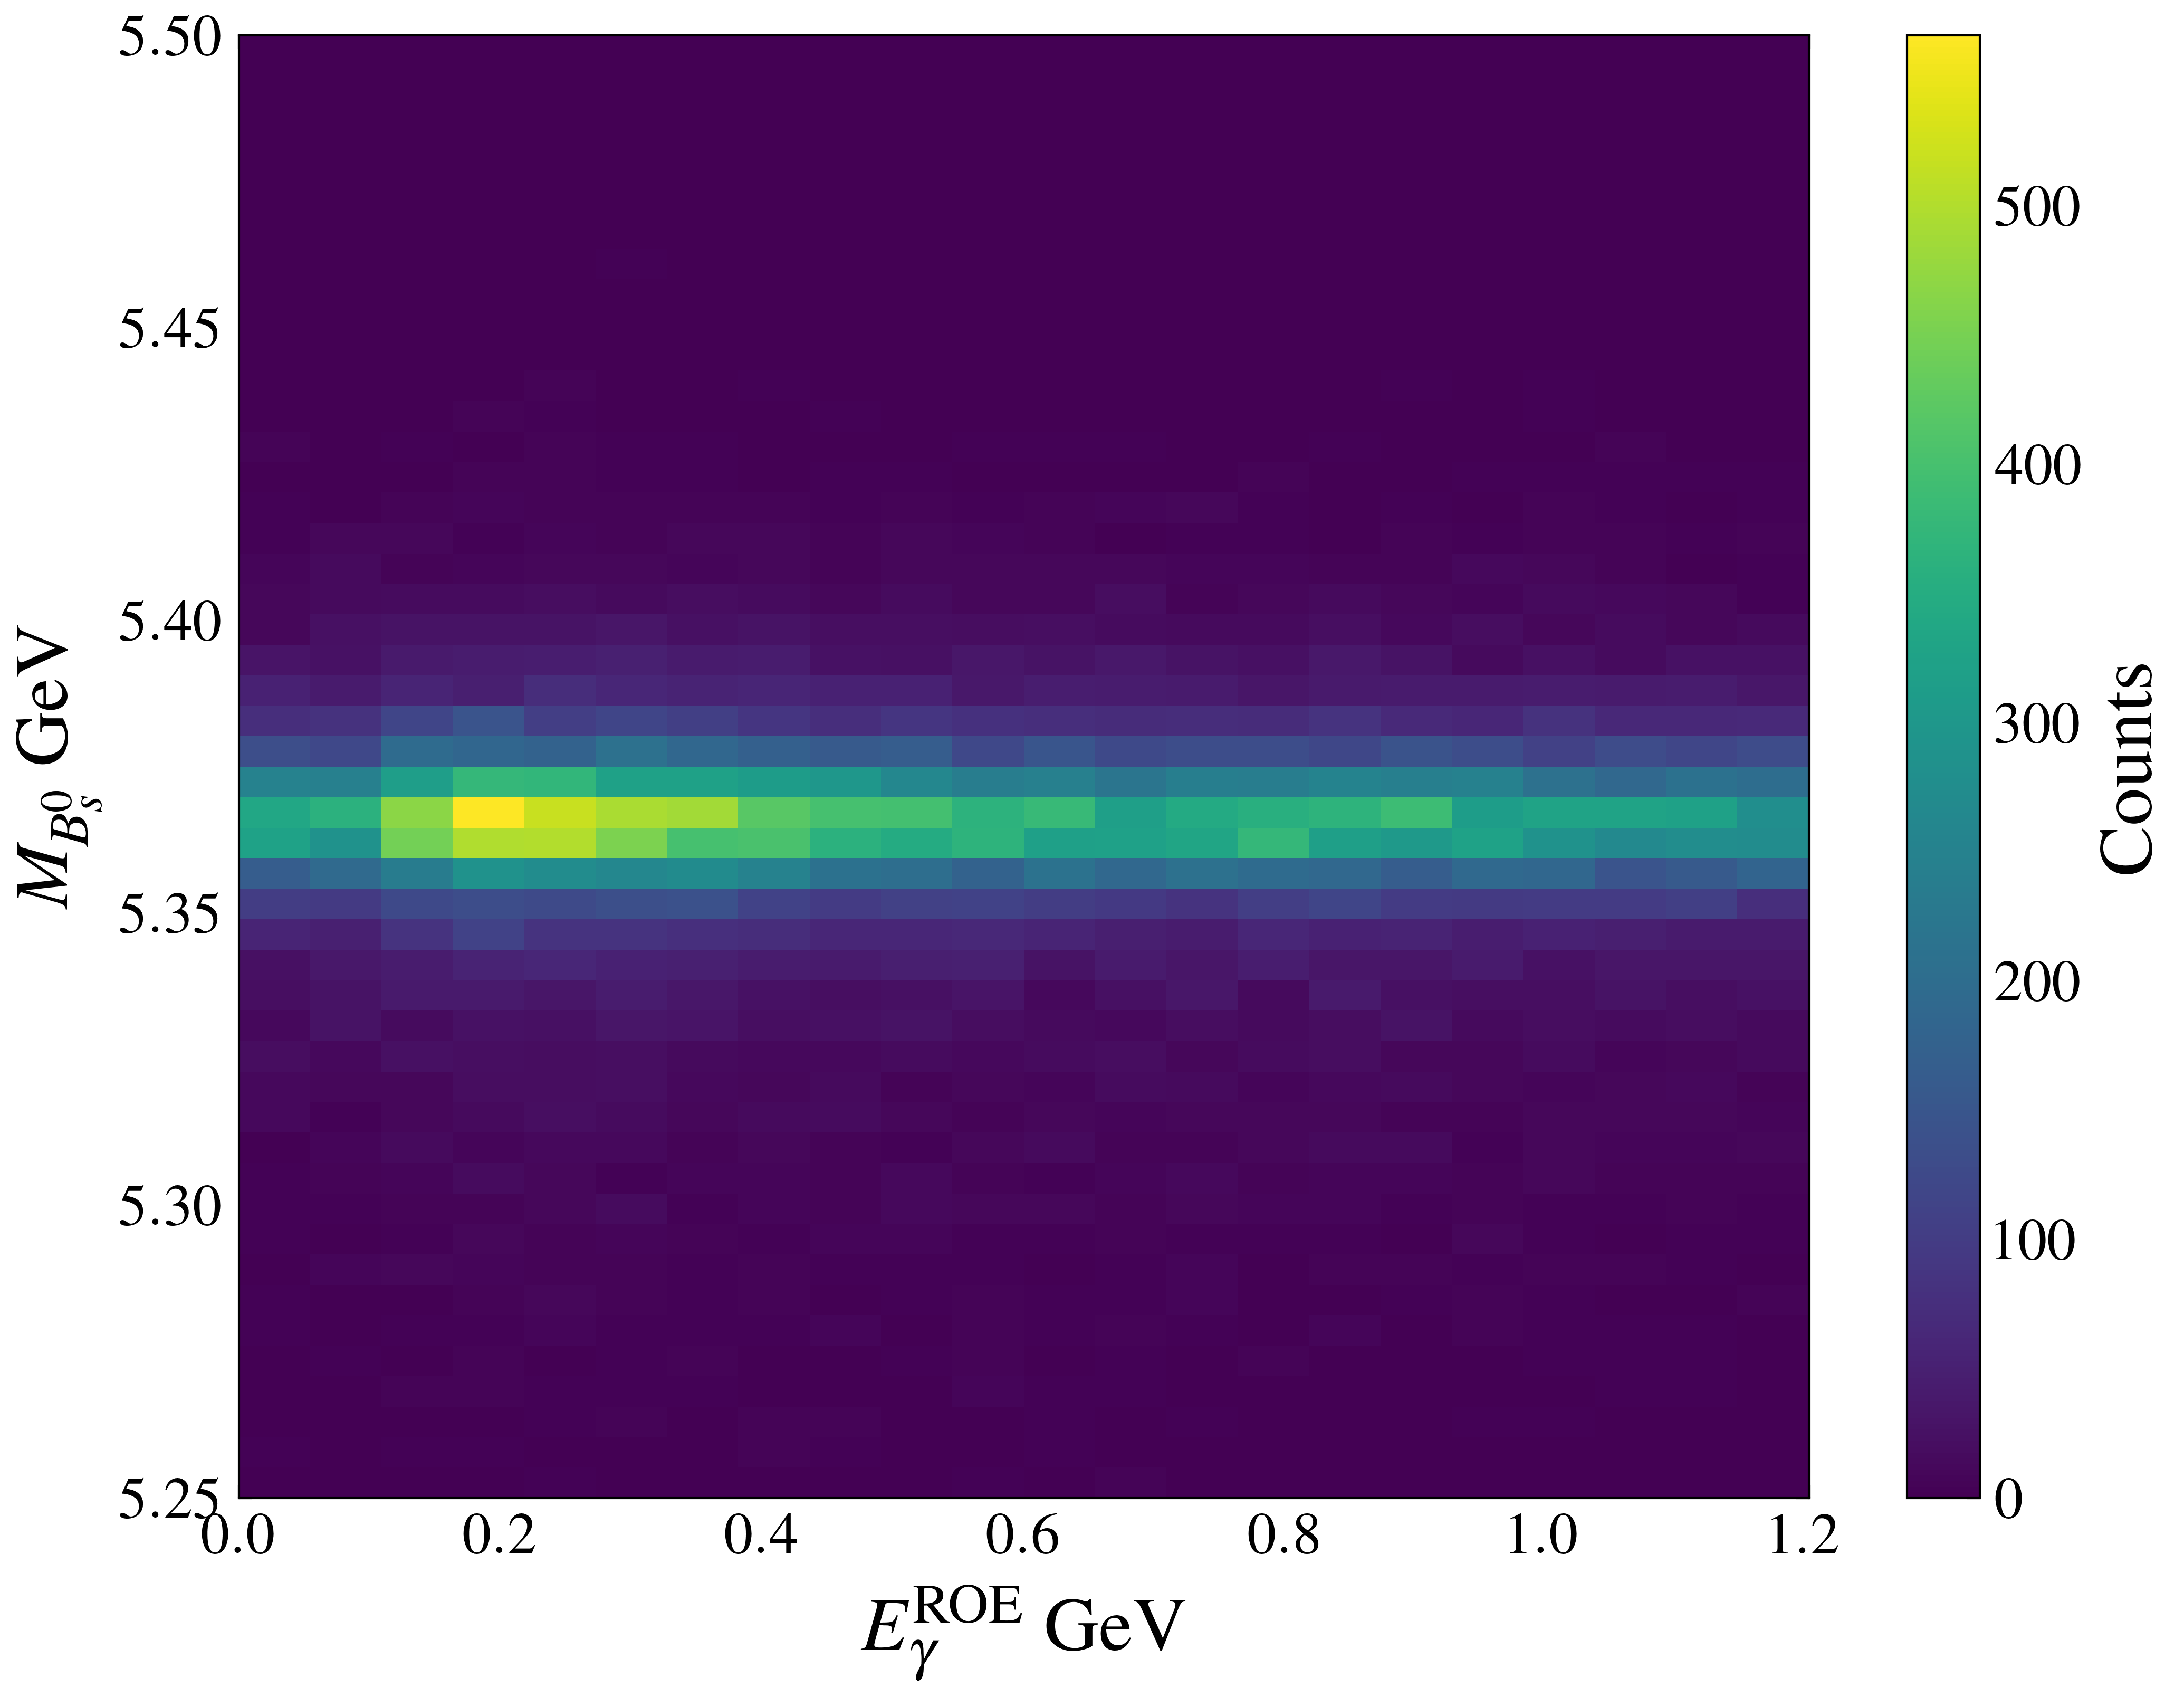

In [34]:
values = selected_data[["E_gamma_in_ROE", "MBtag"]].values

counts, _ = np.histogramdd(values, bins=(bins_x, bins_y))
bin_centers = [0.5 * (b[:-1] + b[1:]) for b in (bins_x, bins_y)]
bin_centers = np.meshgrid(*bin_centers, indexing='ij')



plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}\ \mathrm{GeV}$")
plt.ylabel(r"$M_{B_s^0}\ \mathrm{GeV}$")
plt.colorbar(pmesh, label="Counts")
plt.savefig("output/bsbs_E_ROE_M_Bs.pdf", dpi=700)
plt.show()

In [35]:
hist = hist_approx()
hist.put_hist(bin_centers, counts)

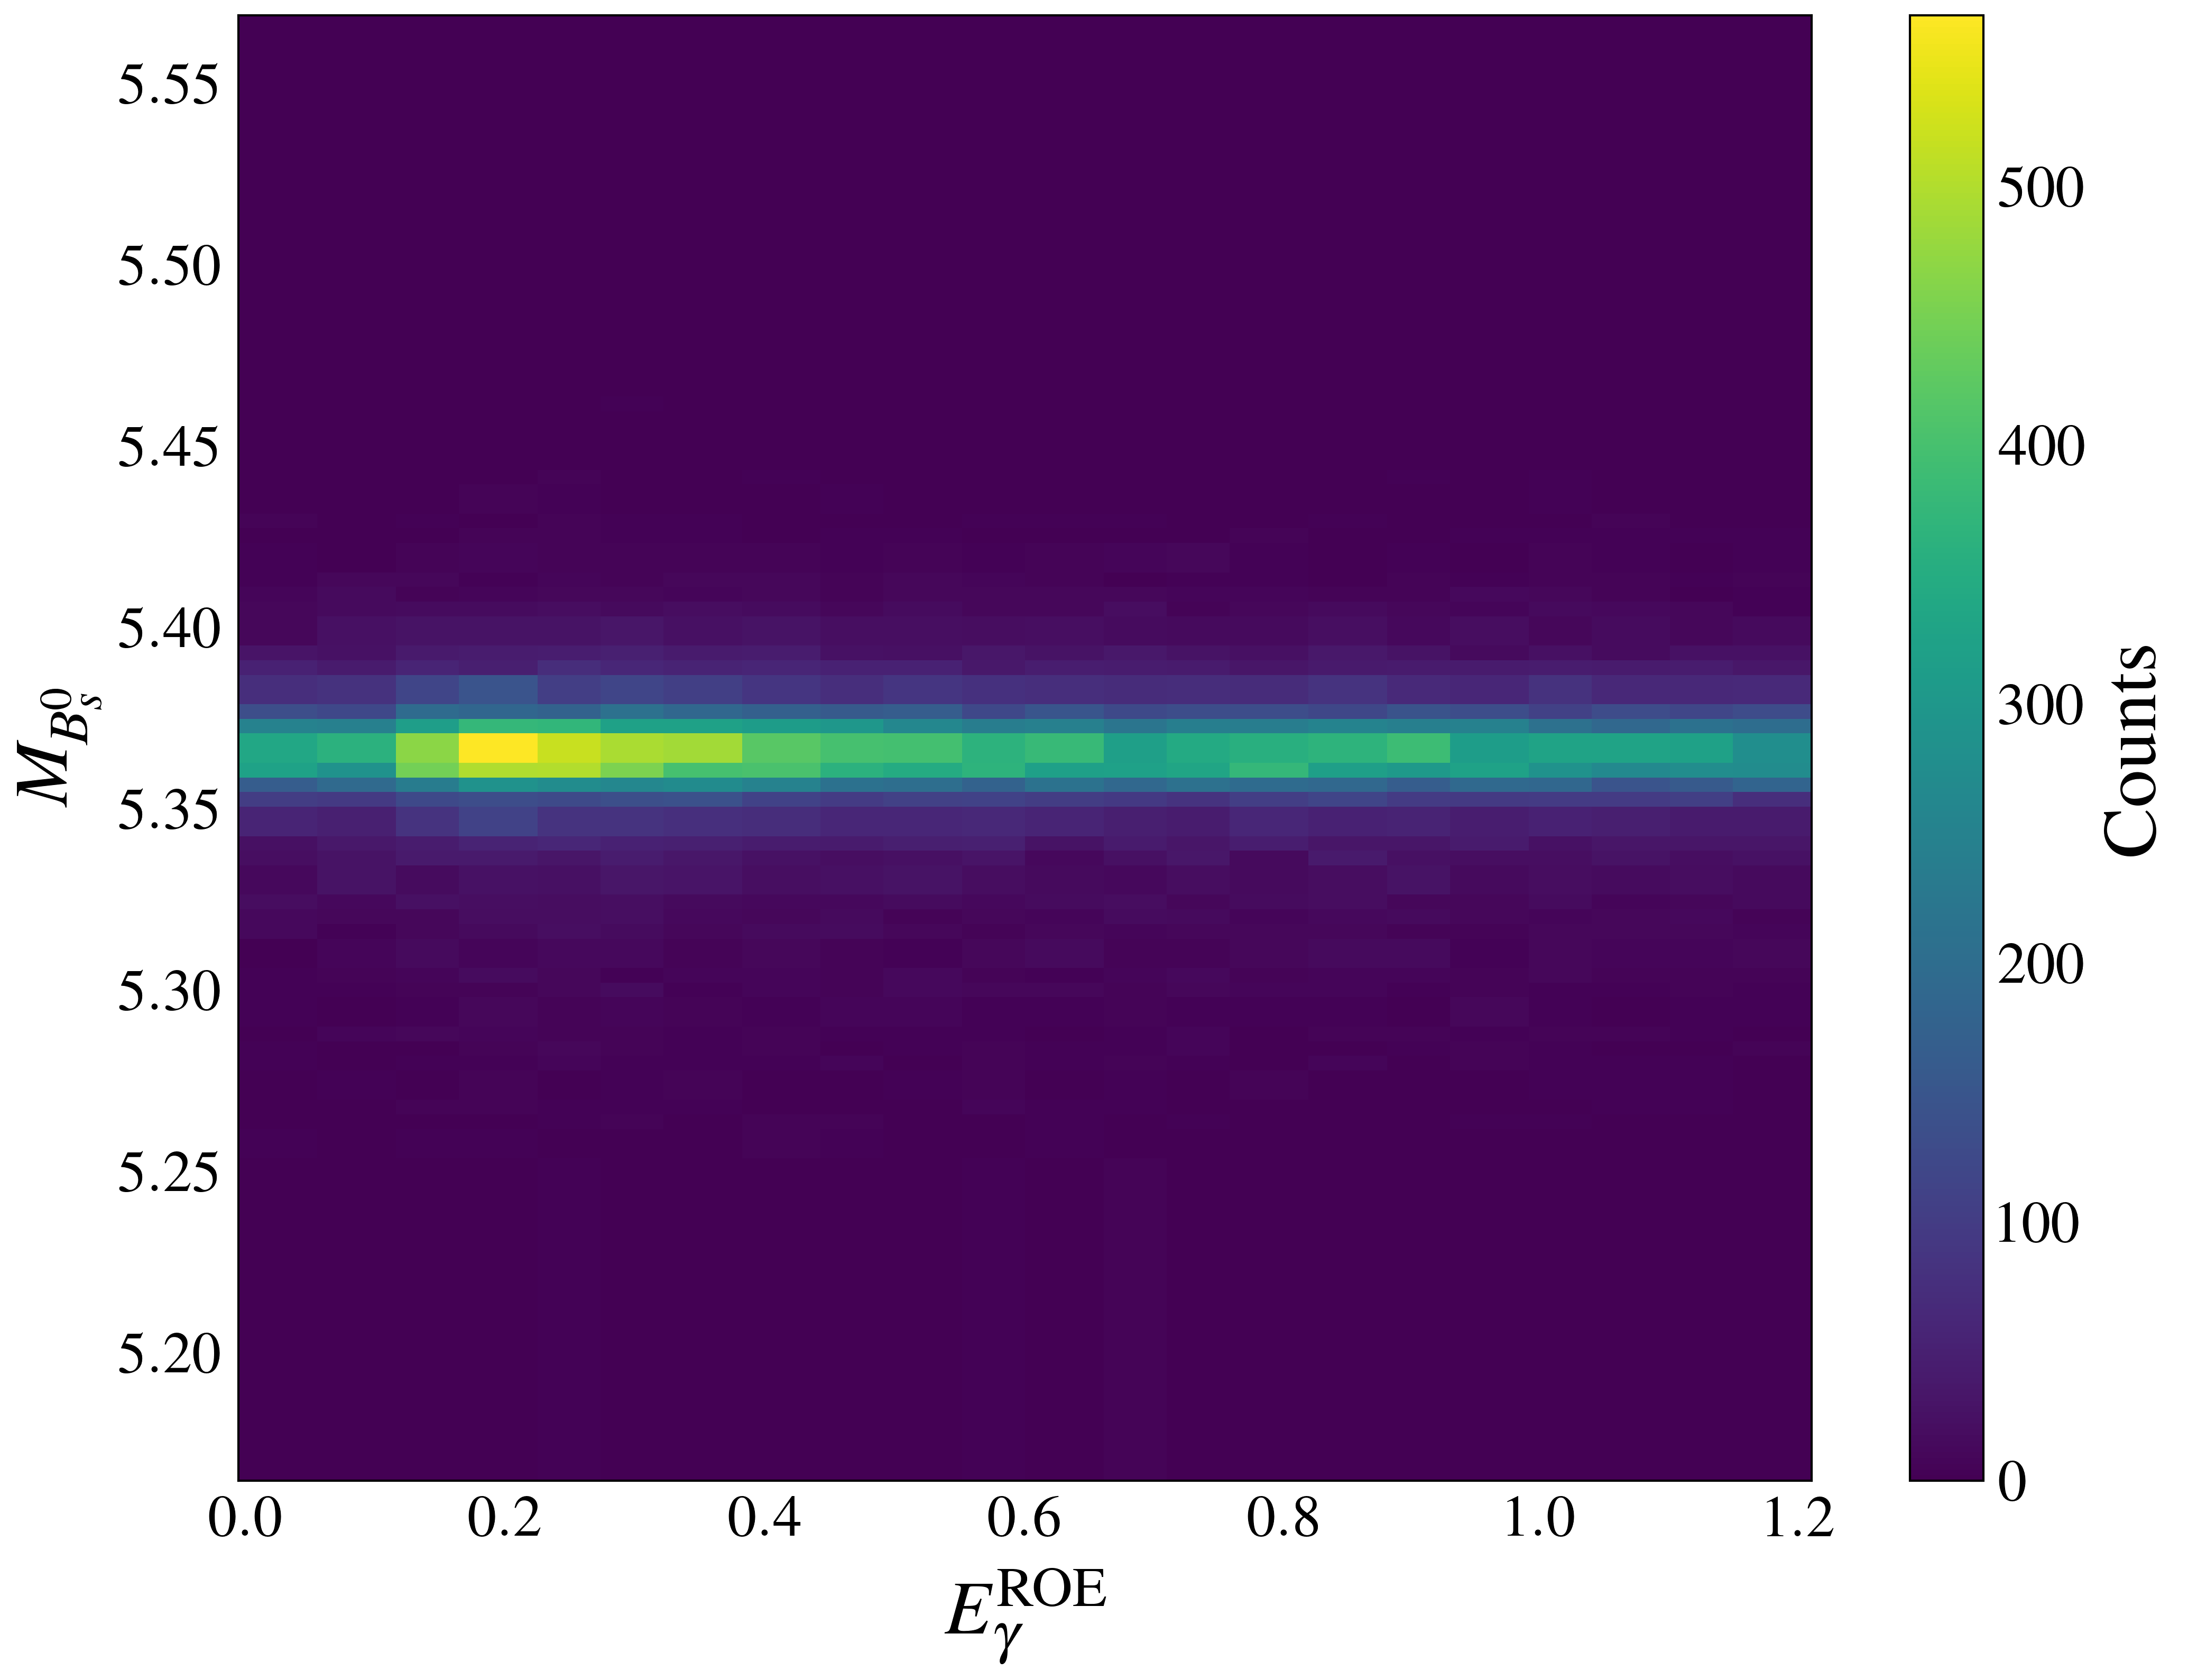

In [36]:
x = np.linspace(0, 1.2, 100)
y = np.linspace(BS0 - 0.2, BS0 + 0.2, 100)
X, Y = np.meshgrid(x, y, indexing='ij')
val = hist.get_counts([X,Y])

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(X, Y, val)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_s^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [37]:
hist.save_hist("output/bsbs.json")